In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams 
rcParams["font.size"] = 14

# example 1: identify a ricker wavelet in a time-series


Ricker wavelet:
$$
f(t) = \frac{2}{\sqrt{3\sigma} \pi^{1/4}} \left(1 - \left(\frac{t-t_0}{\sigma}\right)^2\right) e^{\frac{-(t-t_0)^2}{2\sigma^2}}
$$

In [3]:
def ricker(t, sigma, t0=0, amplitude=1):
    t = t-t0
    return amplitude * 2/(np.sqrt(3*sigma)*np.pi**0.25) * (1 - (t/sigma)**2)*np.exp(-t**2/(2*sigma**2))

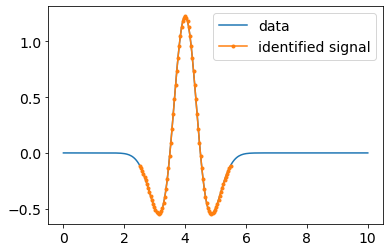

In [4]:
sigma = 0.5
t0 = 4
nt = 256
t = np.linspace(0, 10, nt)
time_series = ricker(t, sigma, t0)

t_ricker = t0 + 3*np.r_[-sigma, sigma]
ricker_inds = (t>=t_ricker.min()) & (t<=t_ricker.max())

plt.plot(t, time_series, label="data")
plt.plot(t[ricker_inds], time_series[ricker_inds], '-', marker=".", label="identified signal")

plt.legend()

## generate data

In [5]:
nt = 256
t = np.linspace(0, 10, nt)
sigma_bounds = np.r_[0.1, 0.5]
amplitude_bounds = np.r_[0.25, 1]
t0_bounds = np.r_[0.1, 9.9]

sigma_threshold = 3

In [6]:
def generate_random_variables(bounds, n):
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

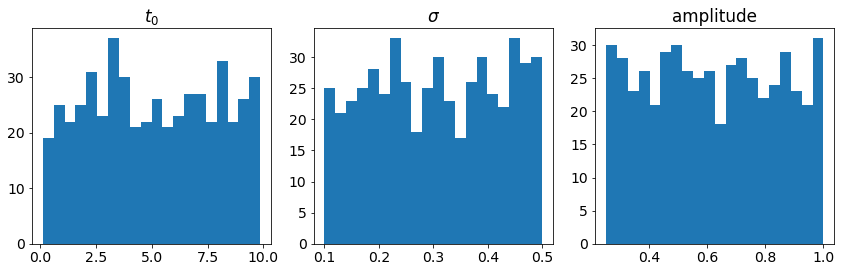

In [7]:
n_train = 512

sigma_train = generate_random_variables(sigma_bounds, n_train)
amplitude_train = generate_random_variables(amplitude_bounds, n_train)
t0_train = generate_random_variables(t0_bounds, n_train)

fig, ax = plt.subplots(1, 3, figsize=(12, 4)) 
for a, var, name in zip(
    ax, 
    [t0_train, sigma_train, amplitude_train], 
    ["$t_0$", "$\sigma$", "amplitude"]
):
    a.hist(var, 20)
    a.set_title(name)

plt.tight_layout()

In [8]:
def generate_data(sigma, t0, amplitude, add_noise=False, percent=5):
    n = len(sigma)
    X = torch.zeros(n, len(t))
    C = torch.zeros(n, len(t))
    
    for i in range(n):
        xi = ricker(t, sigma[i], t0[i], amplitude[i])
        t_ricker = t0[i] + sigma_threshold*np.r_[-sigma[i], sigma[i]]
        ci = ((t>=t_ricker.min()) & (t<=t_ricker.max()))
        
        X[i, :] = torch.from_numpy(xi)
        C[i, :] = torch.from_numpy(ci)
    
    if add_noise is True: 
        noise = percent/100*np.max(np.abs(X.data.numpy()))*torch.from_numpy(np.float32(np.random.randn(n, len(t))))
        X = X + noise
    
    return X, C

In [9]:
X, C = generate_data(sigma_train, t0_train, amplitude_train, add_noise=False)

In [10]:
# validation data 

n_valid = 512

sigma_valid = generate_random_variables(sigma_bounds, n_valid)
amplitude_valid = generate_random_variables(amplitude_bounds, n_valid)
t0_valid = generate_random_variables(t0_bounds, n_valid)

X_valid, C_valid = generate_data(sigma_valid, t0_valid, amplitude_valid)

## plot a subset of the data

In [46]:
def plot_data(Xplot, Cplot, nplot=16, Splot=None, dA=1, ax=None):

    inds = np.random.choice(Xplot.size(0), nplot, replace=False)
    
    if ax is None: 
        fig, ax = plt.subplots(1, 1)

    for i, ind in enumerate(inds):
        xi = dA * i + Xplot[ind, :].numpy()
        ci = (Cplot[ind, :].numpy()).astype(bool)
        if Splot is not None: 
            si = (Splot[ind, :].numpy()).astype(bool)
        ax.plot(t, xi, 'C0')
        ax.plot(t[ci], xi[ci], 'C1o', ms=2, alpha=si[ci] if Splot is not None else 1)

Text(0.5, 1.0, 'subset of training data')

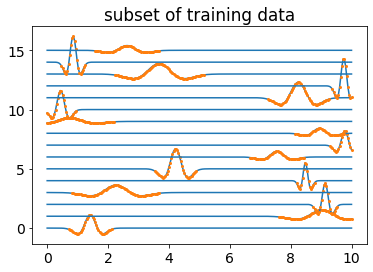

In [47]:
fig, ax = plt.subplots(1, 1)
plot_data(X, C, 16, ax=ax)
ax.set_title("subset of training data")

Text(0.5, 1.0, 'subset of test data')

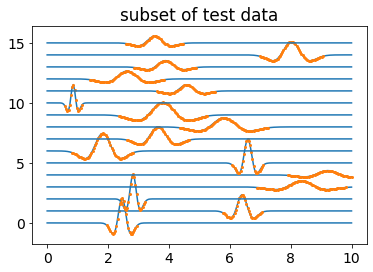

In [48]:
fig, ax = plt.subplots(1, 1)
plot_data(X_valid, C_valid, 16, ax=ax)
ax.set_title("subset of test data")

# design a convolutional network

In [49]:
class ConvNet(nn.Module):
    
    def __init__(self, network_geometry, h=1):
        super().__init__()
        self.h = h
        self.network_geometry=network_geometry
        self.nt = len(network_geometry)-1
    
    def forward(self, X, K, batch_norm, L=None):
        X = X.unsqueeze(1)
        if L is not None:
#             L = L - torch.mean(L.view(-1))
            X = functional.conv1d(X, L, stride=1, padding=1)
            
        for i, Ki, bn in zip(range(self.nt), K, batch_norm): 
#             Ki = Ki - torch.mean(Ki.view(-1))
            z = functional.conv1d(X, Ki, stride=1, padding=1)
            z = bn(z)
            z = functional.relu(z)
                
            if self.network_geometry[i] == self.network_geometry[i+1]:
                z = functional.conv_transpose1d(z, Ki, stride=1, padding=1)
                X = X - self.h*z
            else: 
                X = z
        return X

In [50]:
in_channels = 1
n_class = 2
layer_geometries = [2, 2, 2, n_class]
nlayers = len(layer_geometries)

batch_size = 32 
net = ConvNet(layer_geometries, h=1)

# initialize L
L = nn.Parameter(torch.Tensor(layer_geometries[0], in_channels, 3))
L.data = torch.from_numpy(np.float32(np.random.randn(layer_geometries[0], in_channels, 3)))

# initialize K's and batch normalizations
K = []
batch_norm = []
for i in range(nlayers-1):
    n_in = layer_geometries[i]
    n_out = layer_geometries[i+1]
    Ki = nn.Parameter(torch.Tensor(n_out, n_in, 3))
    Ki.data = torch.from_numpy(np.float32(np.random.randn(n_out, n_in, 3)))
    K.append(Ki)
    
    batch_norm.append(nn.BatchNorm1d(n_out))

In [51]:
lossFunc = nn.CrossEntropyLoss()

def misfit(X,  C):
#     S = functional.conv1d(X, W, stride=1, padding=1)
    S = X
    return lossFunc(S, C.long()), S

In [52]:
# weights for linear classifier    
W = nn.Parameter(torch.randn(n_class, n_class, 3), requires_grad=True)
# bW = nn.Parameter(torch.randn(n_class)*1e-2, requires_grad=True)

nparout = (
    np.prod(L.shape) + np.sum(np.array([np.prod(Ki.shape) for Ki in K]))  
#     np.prod(W.shape)
)

print('Total number of parameter',nparout)
print('Total number of data',C.shape[0])

Total number of parameter 42
Total number of data 512


In [53]:
x = net(X, K, batch_norm, L)
label = C
loss, probs = misfit(x, label)
print('Initial loss = ', loss.detach().numpy())    
print(f'Check:log({n_class}) = ', np.log(n_class))

Initial loss =  0.5604833
Check:log(2) =  0.6931471805599453


In [54]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': L}, {'params': K}],  #, {'params': W}], #{'params': W}, {'params': bW}, {'params': b}], 
    lr = 1e0, momentum=0
)


In [55]:
for epoch in range(30):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X[ind:ind+batch_size, :]
        labels = C[ind:ind+batch_size, :]

        # forward 
        x = net(inputs, K, batch_norm, L)
        lossi, _ = misfit(x, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        
        lossi.backward()
        optimizer.step()
        g += torch.norm(L.grad) + torch.norm(K[0].grad)    
        ind += batch_size
        
    print('%d  %.3f   %.3f'% (epoch+1, loss, g))

print('Finished Training')

1  3.009   1.605
2  1.380   0.272
3  1.189   0.228
4  1.061   0.208
5  0.957   0.175
6  0.881   0.240
7  0.823   0.271
8  0.771   0.222
9  0.726   0.232
10  0.685   0.209
11  0.651   0.192
12  0.623   0.181
13  0.598   0.175
14  0.577   0.161
15  0.558   0.149
16  0.541   0.138
17  0.527   0.119
18  0.514   0.110
19  0.502   0.103
20  0.491   0.097
21  0.481   0.087
22  0.472   0.082
23  0.463   0.075
24  0.455   0.073
25  0.448   0.071
26  0.441   0.070
27  0.434   0.070
28  0.428   0.073
29  0.422   0.072
30  0.416   0.072
Finished Training


In [56]:
# training set
x_train_net = net(X, K, batch_norm, L)
# x_train_net = functional.conv1d(x_train_net, W)
# Strain = functional.softmax(x_train_net, dim=1)
_, Strain = misfit(x_train_net, C)
_, Ctrain = torch.max(Strain, dim=1)

# validation set
xval = net(X_valid, K, batch_norm, L)
# Sval = functional.softmax(xval, dim=1)
_, Sval = misfit(xval, C)
_, Cval = torch.max(Sval, dim=1)

In [57]:
def accuracy(S, labels):
    _, predicted = torch.max(S, dim=1)
    total = np.prod(labels.size())
    correct = (predicted == labels).sum().item()
    return correct/total

In [58]:
print(f"training accuracy: {accuracy(Strain, C):1.4f}")
print(f"test accuracy    : {accuracy(Sval, C_valid):1.4f}")

training accuracy: 0.9823
test accuracy    : 0.9837


In [61]:
fig, ax = plt.subplots(1, 1)
plot_data(X, Ctrain, 16, Splot=Strain[:, 1].detach(), ax=ax)
ax.set_title("segmented training data")

Text(0.5, 1.0, 'segmented training data')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 432x288 with 1 Axes>

Text(0.5, 1.0, 'segmented test data')

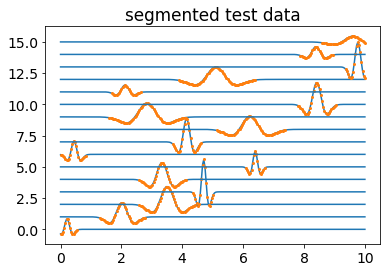

In [42]:
fig, ax = plt.subplots(1, 1)
plot_data(X_valid, Cval, 16, ax=ax)
ax.set_title("segmented test data")

notes: 

- normalize data? max amplitude 1?
